In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MigPreFuncoes
import SlantStack
import scipy

In [2]:
fr=40
nps=200
dt=.005 
rick=MigPreFuncoes.ricker(nps,fr,dt)

sx=10  #index position
sz=0  #index position
nx=110
nz=100;
dt=.005
ntr=nx
dx=10  #meters
dz=dx  #meters
c=1992 #velocidade
tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))
#print(nt)
nd2=nt+1; 
W=np.zeros(2*nt);
#print(W.shape)
W[nt:nt+nps-1]=rick[0:nps-1];
x=np.arange(0,nx)
z=np.arange(0,nz)

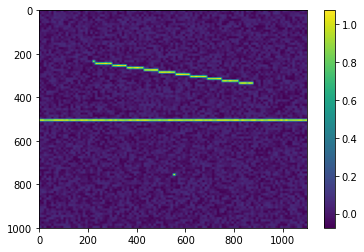

In [3]:
[X,Z]=np.meshgrid(x,z)
zz=(dz*Z)**2
X=(dx*X)                                          
R=X*0.0;

#Refletor Horizontal    
for i in range(int(0),int(nx)):
    R[int(np.round(nz/2)),i]=1
    
#Refletor Dip
x_ini = int(np.round(1*nx/5))
x_fim = int(np.round(4*nx/5))
theta=30

for i in range(x_ini,x_fim):
    z = int(np.round(i*np.cos(theta)) + np.round(nz/5))
    R[z,i]=1

#Ponto Difrator
R[int(np.round(6*nz/8)),int(np.round(nx/2))]=1

nn = np.random.rand(nz,nx)
R = R+(nn-0.5)*0.15

plt.imshow(R, extent=[0, nx*dx, nz*dz, 0], aspect='auto')
plt.colorbar()
plt.show()

In [4]:
#Vagarosidade

SW=np.ones([nz,nx])*1/c

In [5]:
#Tabela do Tempo de Transito

with open('Data/CSG_diffbar/Tabti/raiosTabti.npy', 'rb') as f:
    TTh = np.load(f)

timer=np.round(TTh/dt)+1

print(f"TTh.shape={TTh.shape}")

TTh.shape=(110, 100, 110)


In [6]:
#Creating the synthetic csg

dsx = 1
nsx = nx
ngx = nx
path = "Data/CSG_diffbar/Tabti/dipangle_example"

#files = MigPreFuncoes.kirchhoffModeling(nsx,ngx,dsx,nx,nt,dt,TTh,R,W,path)

In [7]:
files = []

for i in range(nx):
    filename = 'Data/CSG_diffbar/Tabti/dipangle_example_{}'.format(i)
    with open(filename, 'rb') as file:
        (gather) = np.load(file)
        files.append(gather)

In [8]:
#Slant Stack

pmin = -1
pmax = 1
dp = 0.1
xwin=zwin=30
dx=dz=1
x_ini=z_ini=0

#pm,sm = SlantStack.local_window(R,xwin,zwin,x_ini,z_ini,dx,dz,pmin,pmax,dp)

#with open("Data/CSG_diffbar/Tabti/dipangle_dip", "wb") as f:
#    np.save(f,pm)
#    
#with open("Data/CSG_diffbar/Tabti/dipangle_semblance", "wb") as f: 
#    np.save(f,sm)

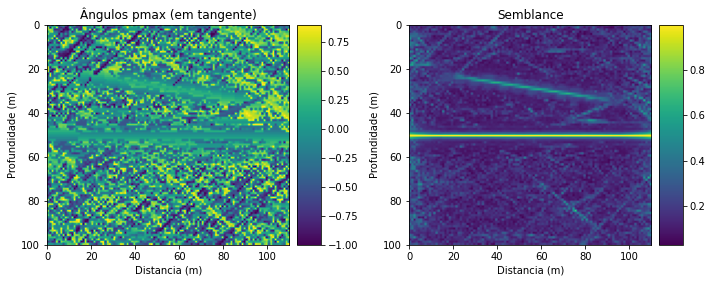

In [9]:
with open("Data/CSG_diffbar/Tabti/dipangle_dip", "rb") as f:
    pm = np.load(f)
    
with open("Data/CSG_diffbar/Tabti/dipangle_semblance", "rb") as f: 
    sm = np.load(f)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(121)
ax1.set_title("Ângulos pmax (em tangente)")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")
im1 = ax1.imshow(pm,extent=[0, nx*dx, nz*dz, 0])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Semblance")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")
im2 = ax2.imshow(sm,extent=[0, nx*dx, nz*dz, 0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [10]:
m_theta = np.arctan(pm)
X = np.sin(m_theta)
Y = np.cos(m_theta)

In [11]:
isx = int(nx/2)
gather1h = files[isx]

In [33]:
#Funções que vou usar para  slope filter:

def tabti_taper(nx,nz,app):
    ar = np.zeros([nz,nx])
    center = int(nx/2)
    window = np.hanning(2*app)

    if center-app<0:
        if center+app>nx:
            lw_2 = int(len(window)/2)            
            ar[:,:] = window[(lw_2 - center):(lw_2 + center)]
        else:
            ar[:,0:(center+app)] = window[abs(center-app):]   
    elif (center+app)>nx:
        ar[:,(abs(center-app)):] = window[0:(nx - abs(center-app))]
    else:
        ar[:,(center-app):(center+app)] = window
        
    #plt.plot(ar)
    #plt.show()
        
    return ar

#####################

def slope_filter(gather,nx,nz):
    fk = scipy.fft.fft2(gather)
    fk = scipy.fft.fftshift(fk,axes=1)
    tap = tabti_taper(nx,nz,5)
    fk_tapered = fk*tap
    new_tapered = scipy.fft.ifft2(fk_tapered)
    return new_tapered

In [13]:
isx=int(nx/2)

amplitudes = []
ws = []
tabtis = []
mig=np.zeros([nz,nx])
mig_diff=np.zeros([nz,nx])
tabti=np.zeros([nz,ntr])

profile=int(nx/2)

for igx in range(0,ntr):
        w = MigPreFuncoes.peso(TTh,dt,X,Y,igx,isx)
        ws.append(w)
        
        t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx] #t_{d}
        t2 = (t<nt)*t
        
        trace1=gather1h.T[np.ix_([igx],t2.flatten().astype(np.int32))] 
        trace1 = trace1.reshape([nz,nx])
        trace2 = trace1*w**4
        trace3 = trace1*(1-w**4)
        
        amplitudes.append(trace1)
        mig[0:nz,0:nx]=mig[0:nz,0:nx] + trace1
        mig_diff[0:nz,0:nx]=mig_diff[0:nz,0:nx] + trace3
        
        tabti[0:nz,igx]=trace1[0:nz,profile]
        tabtis.append(tabti)
        
amplitudes = np.array(amplitudes)
ws = np.array(ws)
tabtis = np.array(tabtis)

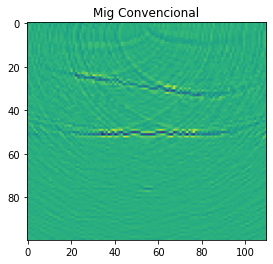

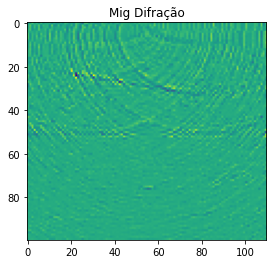

In [14]:
plt.imshow(mig)
plt.title("Mig Convencional")
plt.show()

plt.imshow(mig_diff)
plt.title("Mig Difração")
plt.show()

### Na próxima célula mostro o passo a passo de como filtrar o painel Tabti 

- Transformada de Fourier 2D
- Shift
- Taper
- Transformada Inversa
- Multiplica pela função peso $w$

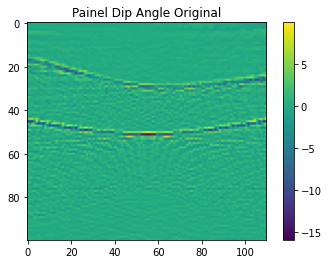

(100,)
(110,)


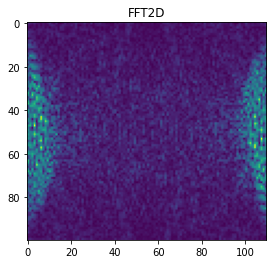

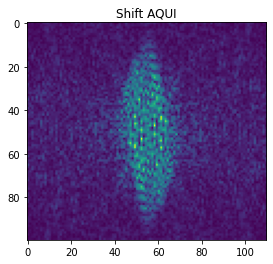

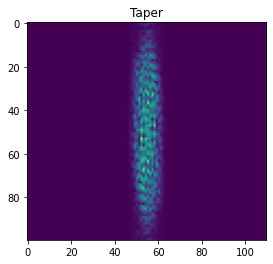

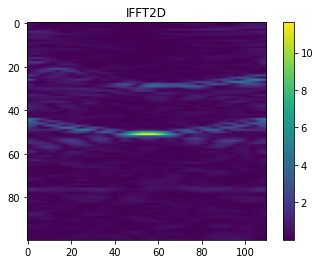

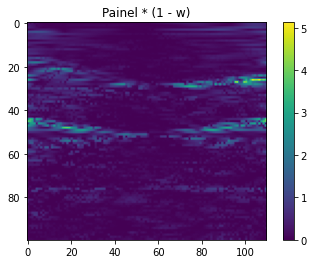

In [39]:
dip_angle = []

for i in range(nx):
    da = amplitudes[:,:,i].T
    dip_angle.append(da)
    
dip_angle = np.array(dip_angle)
dip_angle_55 = dip_angle[55,:,:]

plt.imshow(dip_angle_55)
plt.title("Painel Dip Angle Original")
plt.colorbar()
plt.show()

fk = scipy.fft.fft2(dip_angle_55)

FreqCompRows = np.fft.fftfreq(fk.shape[0])
FreqCompCols = np.fft.fftfreq(fk.shape[1])

print(np.shape(FreqCompRows))
print(np.shape(FreqCompCols))

plt.imshow(np.abs(fk))
plt.title("FFT2D")
plt.show()

fk = scipy.fft.fftshift(fk,axes=1)

plt.imshow(np.abs(fk))
plt.title("Shift AQUI")
plt.show()

tap = tabti_taper(nx,nz,10)
fk_tapered = fk*tap

plt.imshow(np.abs(fk_tapered))
plt.title("Taper")
plt.show()

new_tapered = scipy.fft.ifft2(fk_tapered)

plt.imshow(np.abs(new_tapered))
plt.title("IFFT2D")
plt.colorbar()
plt.show()

dip_final = new_tapered*(1-ws[55]**8)

plt.imshow(np.abs(dip_final))
plt.title("Painel * (1 - w)")
plt.colorbar()
plt.show()

### Agora, faço esse processo para cada painel Tabti do nosso cubo de dados

No fim, a soma dos painéis deve ser semelhante à migração.

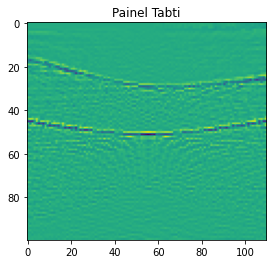

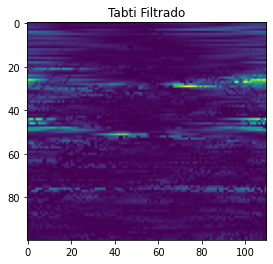

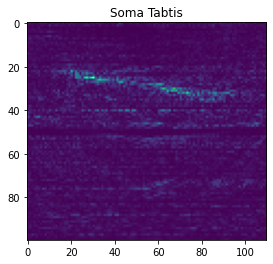

In [34]:
plt.imshow(amplitudes[:,:,isx].T)
plt.title("Painel Tabti")
plt.show()

taps = []

for i in range(nx):
    da = amplitudes[:,:,i].T
    new_tapered = slope_filter(da,nx,nz) #dip filter
    new_tapered = new_tapered*(1-ws[i]**8) #multiplicando pelo peso w
    taps.append(new_tapered)

taps = np.array(taps)

plt.imshow(np.abs(taps[isx,:,:]))
plt.title("Tabti Filtrado")
plt.show()

summed = np.sum(taps,axis=2)

plt.imshow(np.abs(summed).T)
plt.title("Soma Tabtis")
plt.show()

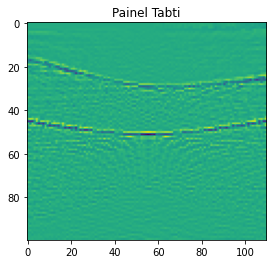

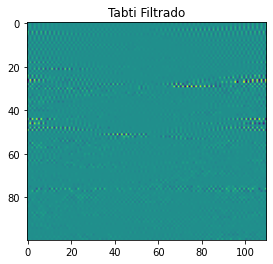

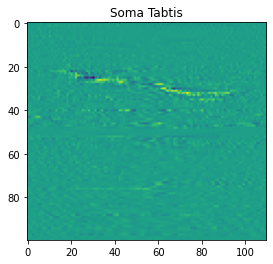

In [35]:
plt.imshow(amplitudes[:,:,isx].T)
plt.title("Painel Tabti")
plt.show()

taps = []

for i in range(nx):
    da = amplitudes[:,:,i].T
    new_tapered = slope_filter(da,nx,nz) #dip filter
    new_tapered = new_tapered*(1-ws[i]**8) #multiplicando pelo peso w
    taps.append(new_tapered)

taps = np.array(taps)

plt.imshow(taps[isx,:,:].real)
plt.title("Tabti Filtrado")
plt.show()

summed = np.sum(taps,axis=2)

plt.imshow((summed.T).real)
plt.title("Soma Tabtis")
plt.show()

***********

# Testando no Velvector

***********

In [67]:
fr=40
nps=200
dt=.005 
rick=MigPreFuncoes.ricker(nps,fr,dt)

sx=10  #index position
sz=0  #index position
nx=110
ntr=nx
nz=100
dt=.005
dx=10  #meters
dz=10  #meters
c=1992 #velocidade m/s

tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))

nd2=nt+1; 
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1];
x=np.arange(0,nx)
z=np.arange(0,nz)

In [68]:
velvector1 = np.loadtxt("Data/velvector") # Modelo de velocidade - 1 coluna em ASCII
vel = np.reshape(velvector1,[201,501]) # Coloca na dimensão correta
vel1 = vel[40:140,250:360] # Recorta um pequeno pedaço do modelovel[40:140,250:360]

c=vel1.min()

tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))

nd2=nt+1; 
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1];
SW = 1./vel1 # Modelo de vagarosidade

In [69]:
SW = 1./vel[39:139,249:359]

dvel1=(np.abs(np.diff(vel1,axis=0)));
mx=np.max(dvel1.flatten('F'));  # Compute Refl Model for vel1;
dvel1=dvel1/mx;
dvel1=np.round(dvel1);

print(np.shape(dvel1))

dvv=dvel1[nz-2,:]
R=np.append(dvel1,dvv[np.newaxis],axis=0);   # We lost a row in R by diff() so we add it back again

#Adicionando ruído no modelo
nn = np.random.rand(nz,nx)
R = R+(nn-0.5)*0.2

with open("Data/CSG/raiosVelvector.npy", 'rb') as f:
    TTh = np.load(f)
    
timer=np.round(TTh/dt)+1

dsx = 5 #talvez dê bug na hora de abrir os files usando esse dsx != 1, preciso testar isso!!!
nsx = nx
ngx = nx

files = []

for i in range(0,nsx,dsx):
    filename = "Data/CSG/velvector_gather_shot_{}".format(i)
    with open(filename, 'rb') as file:
        (gather) = np.load(file)
        files.append(gather)
        
with open("Data/CSG/velvector_dipfield", "rb") as f:
    pm = np.load(f)

with open("Data/CSG/velvector_semblance", "rb") as f:
    sm = np.load(f)
    
m_theta = np.arctan(pm)

X = np.sin(m_theta)
Y = np.cos(m_theta)

isx=55

shot = 55
filename = 'Data/CSG/velvector_gather_shot_{}'.format(int(shot))

with open(filename, 'rb') as file:
    gather1h = np.load(file)

(99, 110)


In [75]:
amplitudes = []
ws = []
tabtis = []
mig=np.zeros([nz,nx])
mig_diff=np.zeros([nz,nx])
tabti=np.zeros([nz,ntr])

profile=int(nx/2)

for igx in range(0,ntr):
        w = MigPreFuncoes.peso(TTh,dt,X,Y,igx,isx)
        ws.append(w)
        
        t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx] #t_{d}
        t2 = (t<nt)*t
        
        trace1=gather1h.T[np.ix_([igx],t2.flatten().astype(np.int32))] 
        trace1 = trace1.reshape([nz,nx])
        trace2 = trace1*w**4
        trace3 = trace1*(1-w**4)
        
        amplitudes.append(trace1)
        mig[0:nz,0:nx]=mig[0:nz,0:nx] + trace1
        mig_diff[0:nz,0:nx]=mig_diff[0:nz,0:nx] + trace3
        
        tabti[0:nz,igx]=trace1[0:nz,profile]
        tabtis.append(tabti)
        
amplitudes = np.array(amplitudes)
ws = np.array(ws)
tabtis = np.array(tabtis)

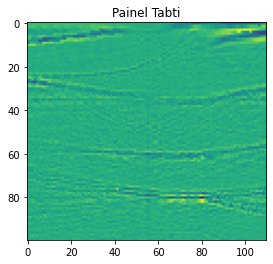

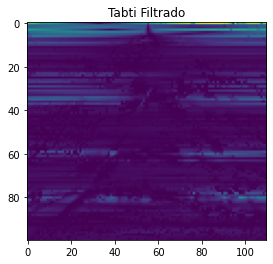

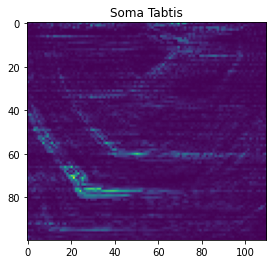

In [76]:
plt.imshow(amplitudes[:,:,isx].T)
plt.title("Painel Tabti")
plt.show()

taps = []

for i in range(nx):
    da = amplitudes[:,:,i].T
    new_tapered = slope_filter(da,nx,nz) #dip filter
    new_tapered = new_tapered*(1-ws[i]**8) #multiplicando pelo peso w
    taps.append(new_tapered)

taps = np.array(taps)

plt.imshow(np.abs(taps[isx,:,:]))
plt.title("Tabti Filtrado")
plt.show()

summed = np.sum(taps,axis=2)

plt.imshow(np.abs(summed).T)
plt.title("Soma Tabtis")
plt.show()

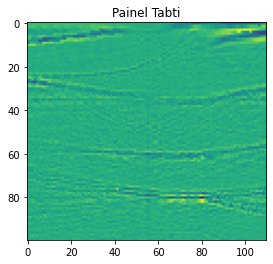

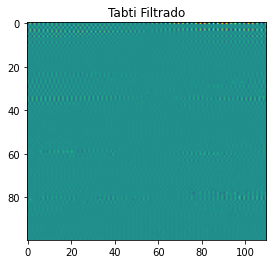

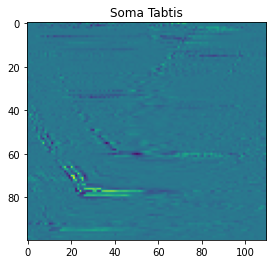

In [77]:
plt.imshow(amplitudes[:,:,isx].T)
plt.title("Painel Tabti")
plt.show()

taps = []

for i in range(nx):
    da = amplitudes[:,:,i].T
    new_tapered = slope_filter(da,nx,nz) #dip filter
    new_tapered = new_tapered*(1-ws[i]**8) #multiplicando pelo peso w
    taps.append(new_tapered)

taps = np.array(taps)

plt.imshow(taps[isx,:,:].real)
plt.title("Tabti Filtrado")
plt.show()

summed = np.sum(taps,axis=2)

plt.imshow((summed.T).real)
plt.title("Soma Tabtis")
plt.show()

D:\Arquivos\anaconda3\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


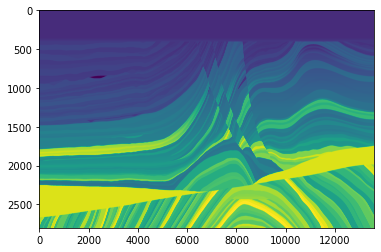

In [40]:
from obspy.io.segy.core import _read_segy
import numpy as np
import matplotlib.pyplot as plt

dado = _read_segy("Data/marmousi_velmodel.segy")

M = np.zeros([len(dado),len(dado[0])])

for i in range(len(dado)):
    M[i] = dado[i]
    
plt.imshow(M.T,aspect="auto")
plt.show()

# Testando Velvector com pontos diff

In [154]:
fr=40
nps=200
dt=.005 
rick=MigPreFuncoes.ricker(nps,fr,dt)

sx=10  #index position
sz=0  #index position
nx=110
nz=100
dt=.005
dx=10  #meters
dz=10  #meters
c=1992 #velocidade m/s

tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))

nd2=nt+1; 
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1];
x=np.arange(0,nx)
z=np.arange(0,nz)

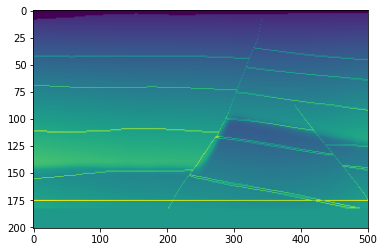

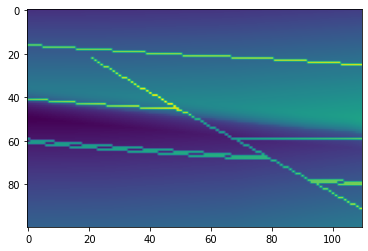

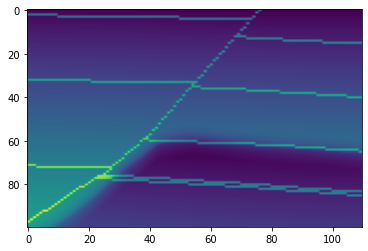

In [218]:
        ###################
        ###### TESTE ######
        ###################

velvector1 = np.loadtxt("Data/velvector") 
vel = np.reshape(velvector1,[201,501])

plt.imshow(vel,aspect="auto")
plt.show()

vel1 = vel[65:165,370:480]

plt.imshow(vel1,aspect="auto")
plt.show()

vel2 = vel[40:140,250:360]

plt.imshow(vel2,aspect="auto")
plt.show()

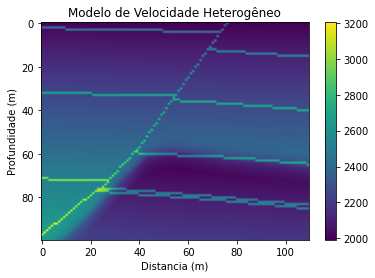

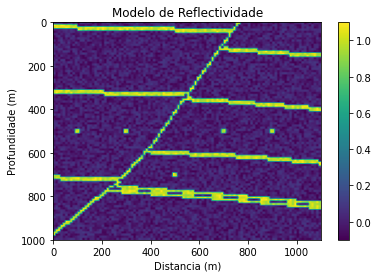

In [155]:
velvector1 = np.loadtxt("Data/velvector") # Modelo de velocidade - 1 coluna em ASCII
vel = np.reshape(velvector1,[201,501]) # Coloca na dimensão correta
vel1 = vel[40:140,250:360] # Recorta um pequeno pedaço do modelovel[40:140,250:360]

c=vel1.min()
tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))

nd2=nt+1; 
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1];
SW = 1./vel1 # Modelo de vagarosidade

plt.imshow(vel1,aspect="auto")#,extent=[0,nx*dx,dz*nz,0])
plt.colorbar()
plt.title("Modelo de Velocidade Heterogêneo")
plt.xlabel("Distancia (m)")
plt.ylabel("Profundidade (m)")
plt.show()


dvel1=(np.abs(np.diff(vel1,axis=0)));
mx=np.max(dvel1.flatten('F'));  # Compute Refl Model for vel1;
dvel1=dvel1/mx;
dvel1=np.round(dvel1);
dvv=dvel1[nz-2,:]
R=np.append(dvel1,dvv[np.newaxis],axis=0);   # We lost a row in R by diff() so we add it back again

#Adding diff points
R[50-1:50+1,10-1:10+1] = 1 #5 #1
R[50-1:50+1,30-1:30+1] = 1 #5 #1
R[50-1:50+1,70-1:70+1] = 1 #5 #1
R[50-1:50+1,90-1:90+1] = 1 #5 #1
R[70-1:70+1,50-1:50+1] = 1 #5 #1

#Adicionando ruído no modelo
nn = np.random.rand(nz,nx)
R = R+(nn-0.5)*0.2

plt.imshow(R, extent=[0, nx*dx, nz*dz, 0], aspect='auto')
plt.title("Modelo de Reflectividade")
plt.xlabel("Distancia (m)")
plt.ylabel("Profundidade (m)")
plt.colorbar()
plt.show()

In [156]:
#Tabela do tempo de trânsito é a mesma

with open("Data/CSG/raiosVelvector.npy", 'rb') as f:
    TTh = np.load(f)
    
timer=np.round(TTh/dt)+1

In [157]:
#Creating the synthetic csg

dsx = 5 #talvez dê bug na hora de abrir os files usando esse dsx != 1, preciso testar isso!!!
nsx = nx
ngx = nx

#files = MigPreFuncoes.kirchhoffModeling(nsx,ngx,dsx,nx,nt,dt,TTh,R,W,"Data/CSG/Diff_velvector_gather_shot")

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:14<00:00,  3.37s/it]


In [159]:
files = []

for i in range(0,nsx,dsx):
    filename = "Data/CSG/Diff_velvector_gather_shot_{}".format(i)
    with open(filename, 'rb') as file:
        (gather) = np.load(file)
        files.append(gather)

In [160]:
pmin = -2
pmax = 2
dp = 0.1
xwin=zwin=30
x_ini=z_ini=0

#pm,sm = SlantStack.local_window(R,xwin,zwin,x_ini,z_ini,dx,dz,pmin,pmax,dp) 
#
#with open("Data/CSG/Diff_velvector_dipfield", "wb") as f: 
#    np.save(f, pm)
#    
#with open("Data/CSG/Diff_velvector_semblance", "wb") as f: 
#    np.save(f, sm)

with open("Data/CSG/Diff_velvector_dipfield", "rb") as f:
    pm = np.load(f)

with open("Data/CSG/Diff_velvector_semblance", "rb") as f:
    sm = np.load(f)

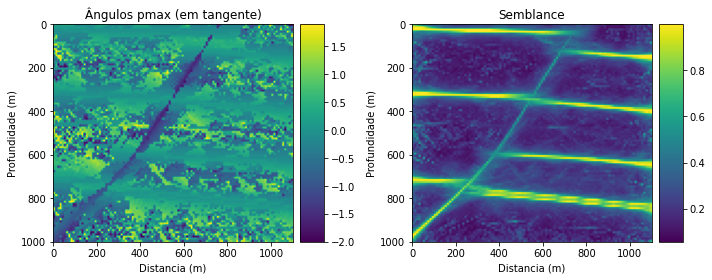

In [161]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(121)
ax1.set_title("Ângulos pmax (em tangente)")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")
im1 = ax1.imshow(pm,extent=[0, nx*dx, nz*dz, 0])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Semblance")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")
im2 = ax2.imshow(sm,extent=[0, nx*dx, nz*dz, 0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [162]:
m_theta = np.arctan(pm)

X = np.sin(m_theta)
Y = np.cos(m_theta)

In [191]:
import importlib
importlib.reload(MigPreFuncoes)
importlib.reload(SlantStack)

<module 'SlantStack' from 'C:\\Users\\guilh\\Desktop\\Code\\SeismicDiffractions\\SlantStack.py'>

In [192]:
#win=20*dt #(metade) janela em tempo em cada etapa
#dwin=dt
#app=20 # abertura em traços

shot = 60

filename = 'Data/CSG/teste_{}'.format(int(shot))
file_original = 'Data/CSG/velvector_gather_shot_{}'.format(int(shot))

#with open(filename, 'rb') as file:
#    gather1t = np.load(file)
    
#with open(file_original, 'rb') as file:
#    gather_original = np.load(file)

with open(file_original, 'rb') as file:
    gather1t = np.load(file)

gather1=gather1t[0:nt,:]
isx=shot

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.10it/s]


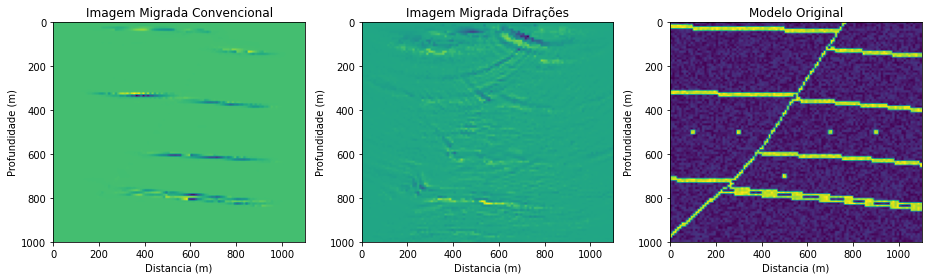

In [193]:
dwin=dt
win=10*dt #(metade) janela em tempo em cada etapa
app_ref=20 # abertura reflexões
app_dif=50 # abertura difrações

refl,diff = MigPreFuncoes.migration_teste(gather1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

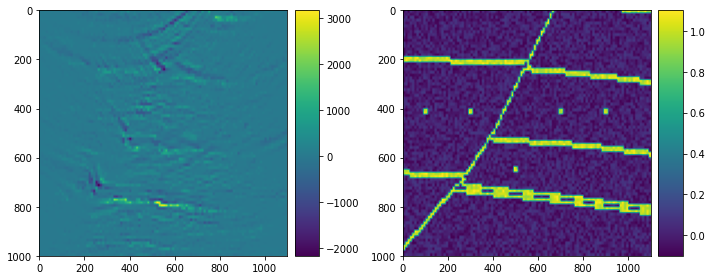

In [175]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(diff[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.imshow(R[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

22it [02:14,  6.10s/it]


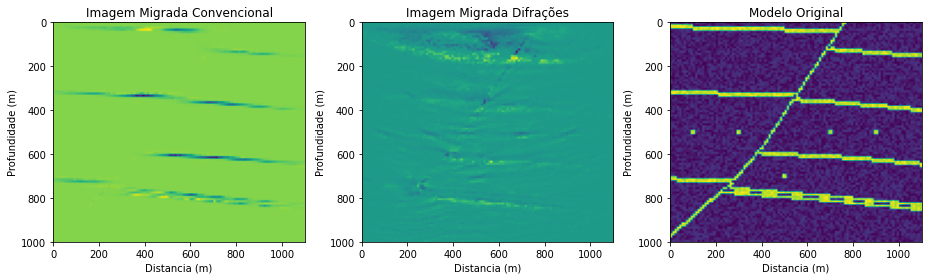

In [194]:
refl_stackteste,diff_stackteste = MigPreFuncoes.migration_teste(files,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

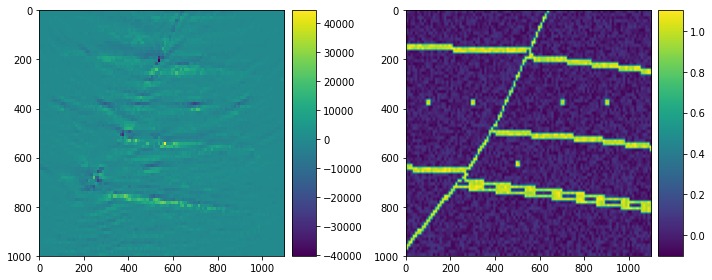

In [200]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(diff_stackteste[20:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0],interpolation="nearest")
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.imshow(R[20:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
#continuo usando a sm (semblance) como fator para a migração convencional? ou isso não faz sentido?